In [1]:
# !pip install matplotlib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from functools import partial
from os import listdir
from os.path import join, isfile
from tempfile import TemporaryDirectory
from zipfile import ZipFile

import numpy as np
import pandas as pd

from IPython.display import display

# Load top 50 marketcap historical data from Kaggle dataset

In [4]:
def get_attr(data_all, field_name):
    """
    Get attribute for each value in the dictionary.
    
    :param data_all: Data in dict format of which its values
      are dataframes.
    """
    attr = {
        key: df[field_name]
        for key, df in data_all.items()
    }
    attr = pd.DataFrame(attr)
    attr = attr.ffill().groupby(attr.index.date).first()
    attr.index = pd.to_datetime(attr.index)
    attr = attr.groupby(attr.index.date).last()
    attr.index = pd.to_datetime(attr.index)
    return attr

In [5]:
estimation_universe_all = {}

with ZipFile("crypto_estimation_universe.zip", 'r') as zip_ref:
    with TemporaryDirectory() as temp_dir:
        zip_ref.extractall(temp_dir)
        files = [
            (join(temp_dir, f), f.replace(".csv", ""))
            for f in listdir(temp_dir) 
            if isfile(join(temp_dir, f))
        ]

        for file_path, name in files:
            df = pd.read_csv(file_path)
            df = df.set_index("date")
            df.index = pd.to_datetime(df.index)
            estimation_universe_all[name] = df

# Prepare the data

- Retrieve prices and derivate daily returns from them
- Retrieve volumes and marketcap

In [6]:
# Prices and daily returns
est_universe_prices = get_attr(estimation_universe_all, "price")
est_universe_returns = est_universe_prices.pct_change()
# Volumns
est_universe_volumes = get_attr(estimation_universe_all, "total_volume")
# Marketcap
est_universe_marketcap = get_attr(estimation_universe_all, "market_cap")

# Construct estimation universe

Estimation universe is constructed by selecting the instruments by the following
criteria in the ascending order

1. Active trading for at least 6 months
2. Median of past 6-month daily (absolute) returns should exceed 0.5% (Stablecoin exclusion)
3. Rank the instruments by market cap and exclude the lower rank instruments if they are
   highly correlated with other instruments. (For example, ETH and staked Ether)


In [7]:
def correlation_rank_selection(
    d_rank, 
    returns,
    rolling_window=90,
    correlation_threshold=0.9
):
    if d_rank.isnull().all():
        return pd.Series(np.nan, index=d_rank.index)
    ranks = d_rank.sort_values()
    validity = ranks.notnull()
    d_correlations = returns.loc[:d_rank.name, validity].tail(rolling_window).corr()
    selected = []
    for name, i_validity in ranks.items():
        if np.isnan(i_validity):
            continue
        if not selected:
            selected.append(name)
            continue
        if (d_correlations.loc[selected, name].abs() > correlation_threshold).any():
            continue
        selected.append(name)
    valid_instmts = pd.Series(True, index=selected)
    valid_instmts = valid_instmts.reindex(d_rank.index)
    return valid_instmts

<Axes: title={'center': 'Number of valid instruments in universe'}>

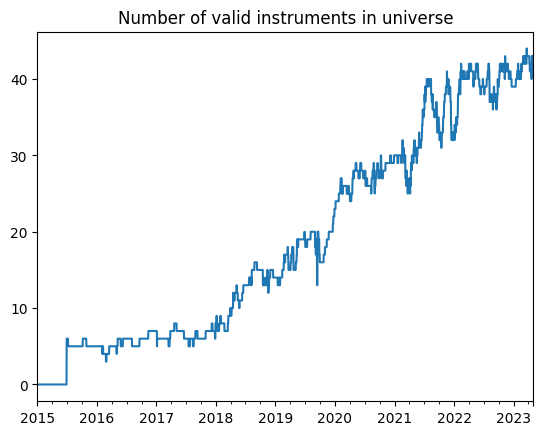

In [8]:
est_universe_validity = (est_universe_marketcap > 0.0).rolling(210, min_periods=180).sum() > 180
est_universe_validity = (
    est_universe_validity & 
    (est_universe_returns.abs().rolling(210, min_periods=180).median() > 0.005)
)
est_universe_marketcap_rank = est_universe_marketcap.where(est_universe_validity).rank(axis=1, ascending=False)
est_universe_validity = (
    est_universe_marketcap_rank.apply(partial(correlation_rank_selection, returns=est_universe_marketcap_rank, rolling_window=90), axis=1)
    .fillna(False)
)
est_universe_validity.index = pd.to_datetime(est_universe_validity.index)
est_universe_validity.sum(axis=1).plot(title="Number of valid instruments in universe")

# Build factor risk model from estimation universe

In [9]:
from tqdm import tqdm
from fpm_risk_model.rolling_factor_risk_model import RollingFactorRiskModel
from fpm_risk_model.statistical.pca import PCA
from fpm_risk_model.pipeline import dump_rolling_factor_risk_model, load_rolling_factor_risk_model

In [10]:
model = PCA(n_components="mle")
rolling_risk_model = RollingFactorRiskModel(
    window=180,
    model=model,
    show_progress=True,
)
rolling_risk_model.fit(
    est_universe_returns.where(est_universe_returns.abs() < 0.20),
    validity=est_universe_validity,
)  

In [11]:
rolling_risk_model.write_directory("/Users/gavinchan/workspace/fpmodel-data/crypto/est-pca-model")

# Load all crypto OHLCV data

In [12]:
model_universe_all = {}

# with tarfile.open("crypto_estimation_universe.zip", "r:gz") as gzip_file:
with ZipFile("crypto_model_universe.zip", 'r') as zip_ref:
    with TemporaryDirectory() as temp_dir:
        zip_ref.extractall(temp_dir)
        price_data_dir = join(temp_dir, "Price-Data")
        files = [
            (join(price_data_dir, f), f.replace(".csv", ""))
            for f in listdir(price_data_dir) 
            if isfile(join(price_data_dir, f))
        ]

        for file_path, name in files:
            df = pd.read_csv(file_path)
            df = df.set_index("Date")
            df.index = pd.to_datetime(df.index)
            model_universe_all[name] = df

In [13]:
# Compute prices
model_universe_prices = get_attr(model_universe_all, "Adj Close")
model_universe_returns = model_universe_prices.pct_change()
# Compute volumes
model_universe_volumes = get_attr(model_universe_all, "Volume")
model_universe_volumes_usd = model_universe_volumes * model_universe_prices

# Construct model universe

Model universe is constructed by selecting the instruments by the following
criteria in the ascending order

1. Active trading for at least 6 months
2. Median of past 6-month daily (absolute) returns should exceed 0.5% (Stablecoin exclusion)
3. Top 50% active daily volume among all instruments


3155it [02:44, 19.20it/s] 


<Axes: title={'center': 'Number of valid instruments in universe'}>

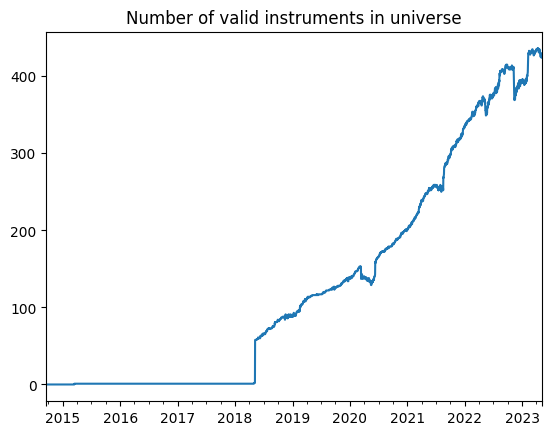

In [14]:
model_universe_validity = (model_universe_volumes > 0.0).rolling(210, min_periods=180).sum() > 180
model_universe_validity = model_universe_validity & (model_universe_returns.abs().rolling(210, min_periods=180).median() > 0.005)
model_universe_volume_usd_rank = model_universe_volumes_usd.where(model_universe_validity).rank(axis=1, ascending=False)
model_universe_volume_usd_rank = (
    model_universe_volume_usd_rank
    .where(model_universe_volume_usd_rank.lt(model_universe_validity.sum(axis=1) * 0.5, axis=0))
)
model_universe_volume_usd_rank_validity = pd.DataFrame().reindex_like(model_universe_volume_usd_rank)
for date, row in tqdm(model_universe_volume_usd_rank.iterrows()):
    model_universe_volume_usd_rank_validity.loc[date] = (
        correlation_rank_selection(
            d_rank=row,
            returns=model_universe_returns,
            rolling_window=90
        )
    )
model_universe_validity &= model_universe_volume_usd_rank_validity
model_universe_validity.index = pd.to_datetime(model_universe_validity.index)
model_universe_validity.sum(axis=1).plot(title="Number of valid instruments in universe")

# Transform the risk model from estimation to model universe

The transformation reuses the factor returns to compute the new set of factor exposures and idiosyncratic returns on the model universe, even though the instrument names on the two universes are different.

It gives covariance matrix on a much larger number of instruments. For example, in 2023, the number of instruments in estimation and model universes are around 40 and 400 respectively.

In [15]:
rolling_risk_model.transform(
    model_universe_returns.where(model_universe_returns.abs() < 0.2),
    validity=model_universe_validity,
)

# Forecasting accuracy

After the risk model has been transformed into the model universe space, it is important to examine its forecasting accuracy.

In the library, the following methods are provided

1. Bias statistics
2. Value at Risk (VaR)

Both methods require passing the rolling risk model and the portfolio weights. The portfolio weights should be a Dataframe
indicating the instrument weights per date and each date the weights should be summed up to 1. With portfolio weights, 
the portfolio realized volatility, produced by its weights and returns, is compared with the forecast volatility produced
by risk models.

<Axes: >

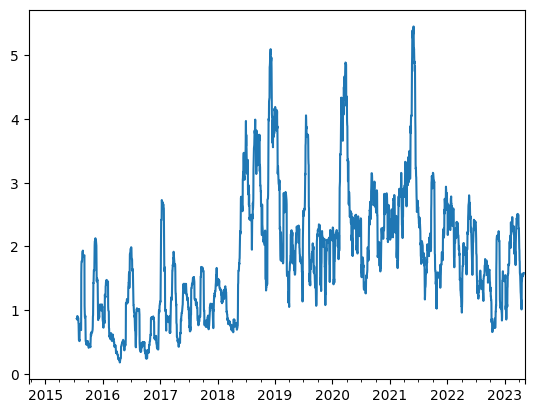

In [16]:
from fpm_risk_model.accuracy import compute_bias_statistics
weights = model_universe_validity.div(model_universe_validity.sum(axis=1), axis=0)
bias_statistics = compute_bias_statistics(
    X=model_universe_returns.where(model_universe_returns.abs() < 0.2),
    weights=weights,
    window=21,
    rolling_risk_model=rolling_risk_model,
)
bias_statistics.plot()

<Axes: >

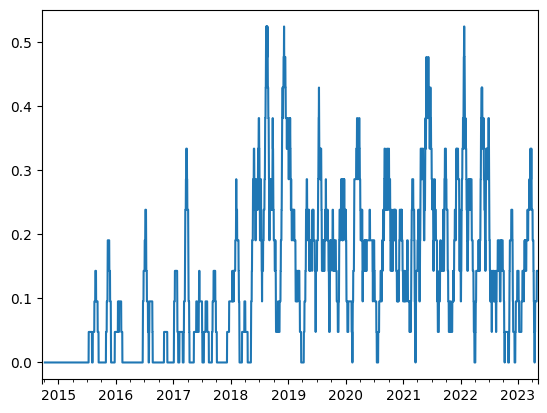

In [17]:
from fpm_risk_model.accuracy import compute_value_at_risk_rolling_breach_statistics
weights = model_universe_validity.div(model_universe_validity.sum(axis=1), axis=0)
var_breach_statistics = compute_value_at_risk_rolling_breach_statistics(
    X=model_universe_returns.where(model_universe_returns.abs() < 0.2),
    weights=weights,
    window=21,
    rolling_risk_model=rolling_risk_model,
)
var_breach_statistics.plot()